In [1]:
import math
import numpy  as np
import random as rnd
import sys, os, glob
import KTimage as KT
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def_RAD2DEG         = 180.0/math.pi
def_DEG2RAD         = math.pi/180.0
Float_Format        = "{:3.2f}"

import tensorflow as tf
from libs.activations import lrelu
from libs.utils import corrupt
import pickle

In [27]:
tf.reset_default_graph()
# %%
batch_size = 10
input_shape=[batch_size, 40, 320, 1]
n_filters=[1, 70, 70, 70, 70]
filter_sizes=[[8, 10], [8, 14], [2, 8], [1, 1]]
strides_i=[[4, 5], [1, 7], [1, 1], [1, 1]]
    
# %%
# input to the network
x = tf.placeholder(tf.float32, input_shape, name='x')

# %%
# ensure input is 4-d.
if len(x.get_shape()) == 4:
    x_tensor = x
else:
    raise ValueError('Unsupported input dimensions')
current_input = x_tensor

# %%
# Build the encoder
encoder = []
shapes = []
for layer_i, n_output in enumerate(n_filters[1:]):
    n_input = current_input.get_shape().as_list()[3]
    shapes.append(current_input.get_shape().as_list())
    W = tf.Variable(
        tf.random_uniform([filter_sizes[layer_i][0], filter_sizes[layer_i][1], n_input, n_output],
            -1.0 / math.sqrt(n_input), 1.0 / math.sqrt(n_input)))
    b = tf.Variable(tf.zeros([n_output]))
    encoder.append(W)
    # the fully connected layer
    output = lrelu(
        tf.add(tf.nn.conv2d(
            current_input, W, strides=[1, strides_i[layer_i][0], strides_i[layer_i][1], 1], padding='VALID'), b))
#     print('layer ', layer_i, 'has output shape =', output.get_shape())
    current_input = output

# %%
# the latent representation
z = current_input
print(ae['z'].get_shape())
encoder.reverse()
shapes.reverse()
strides_i.reverse()

# %%
# Build the decoder using the same weights
for layer_i, shape in enumerate(shapes):
    W = encoder[layer_i]
    b = tf.Variable(tf.zeros([W.get_shape().as_list()[2]]))
    output = lrelu(tf.add(
        tf.nn.conv2d_transpose(
            current_input, W,
            tf.stack([tf.shape(x)[0], shape[1], shape[2], shape[3]]),
            strides=[1, strides_i[layer_i][0], strides_i[layer_i][1], 1], padding='VALID'), b))
#     print('layer ', layer_i, 'has output shape =', output.get_shape())
    current_input = output

# %%
# now have the reconstruction through the network
y = current_input
# cost function measures pixel-wise difference
cost1 = tf.reduce_sum(tf.square(y - x_tensor))

Head, Place = tf.split(z, [40, 30], 3)
Head1 = Head[0:batch_size-1, :, :, :]
Head2 = Head[1:batch_size, :, :, :]
Place1 = Place[0:batch_size-1, :, :, :]
Place2 = Place[1:batch_size, :, :, :]
steps = tf.placeholder(tf.float32, [batch_size-1], name='steps')
angles = tf.placeholder(tf.float32, [batch_size-1], name='angles')
cost2 = tf.reduce_sum((steps != 0)*tf.reduce_sum(tf.pow((Head1-Head2), 2), [1, 2, 3]))\
    + tf.reduce_sum((angles != 0)*tf.reduce_sum(tf.pow((Place1-Place2), 2), [1, 2, 3]))
beta = 100
cost = cost1 + beta*cost2

# %%
ae = {'x': x, 'steps':steps, 'angles':angles, 'z': z, 'Head': Head, 'Place': Place, 'y': y, 'cost': cost, 'cost1': cost1, 'cost2': cost2}

# %%
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(ae['cost'])

(10, 1, 1, 70)


<class 'numpy.ndarray'> (40000, 40, 320, 1)
mean_img.shape = (40, 320, 1)
<class 'numpy.ndarray'> (40000, 40, 320, 1)
mean_img2.shape = (40, 320, 1)
<class 'numpy.ndarray'> (39999, 3)
(39999,) (39999,)
<class 'numpy.ndarray'> (39999, 3)
(39999,) (39999,)


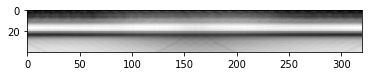

In [7]:
# %%
# load training image
train_images = np.load('train_images.npy')
print(type(train_images), train_images.shape)
mean_img = np.mean(train_images, axis=0)
print('mean_img.shape =', mean_img.shape)
plt.imshow(mean_img[:, :, 0], cmap='gray')

# load training image2
train_images2 = np.load('train_images2.npy')
print(type(train_images2), train_images2.shape)
mean_img2 = np.mean(train_images2, axis=0)
print('mean_img2.shape =', mean_img2.shape)
plt.imshow(mean_img2[:, :, 0], cmap='gray')

# load training cmd
train_cmds = pickle.load(open("train_cmds.p", "rb"))
print(type(train_cmds), train_cmds.shape)
train_steps = train_cmds[:, 0]
train_angles = train_cmds[:, 1]
print(train_steps.shape, train_angles.shape)

# load training cmd2
train_cmds2 = np.load("train_cmds2.npy")
print(type(train_cmds2), train_cmds2.shape)
train_steps2 = train_cmds2[:, 0]
train_angles2 = train_cmds2[:, 1]
print(train_steps2.shape, train_angles2.shape)

In [30]:
# %%
# initialize the weights or load the trained weights
sess = tf.Session()
saved_model = 'modelxxx'

# sess.run(tf.global_variables_initializer())

restorer = tf.train.Saver()
restorer.restore(sess, 'C:/Users/WangYong/Desktop/Thesis/Code/model/' + saved_model)

INFO:tensorflow:Restoring parameters from C:/Users/WangYong/Desktop/Thesis/Code/model/modelxxx


0 cost = 820.582 cost1 = 729.036 cost2 = 0.915462
0 cost = 784.884 cost1 = 680.608 cost2 = 1.04277
1 cost = 941.839 cost1 = 829.788 cost2 = 1.12051
1 cost = 958.316 cost1 = 804.465 cost2 = 1.53851
2 cost = 811.776 cost1 = 729.155 cost2 = 0.826218
2 cost = 785.035 cost1 = 688.149 cost2 = 0.968864
3 cost = 821.729 cost1 = 735.037 cost2 = 0.866927
3 cost = 787.605 cost1 = 689.194 cost2 = 0.984102
4 cost = 808.002 cost1 = 722.464 cost2 = 0.855372
4 cost = 771.448 cost1 = 672.858 cost2 = 0.985897
5 cost = 805.014 cost1 = 721.322 cost2 = 0.836921
5 cost = 780.688 cost1 = 690.829 cost2 = 0.898588
6 cost = 913.325 cost1 = 798.878 cost2 = 1.14446
6 cost = 848.482 cost1 = 719.29 cost2 = 1.29192
7 cost = 821.752 cost1 = 735.322 cost2 = 0.864301
7 cost = 796.084 cost1 = 690.459 cost2 = 1.05624
8 cost = 807.646 cost1 = 725.441 cost2 = 0.822044
8 cost = 775.478 cost1 = 677.76 cost2 = 0.977179
9 cost = 808.646 cost1 = 724.182 cost2 = 0.844637
9 cost = 776.866 cost1 = 682.594 cost2 = 0.942716
10 cost 

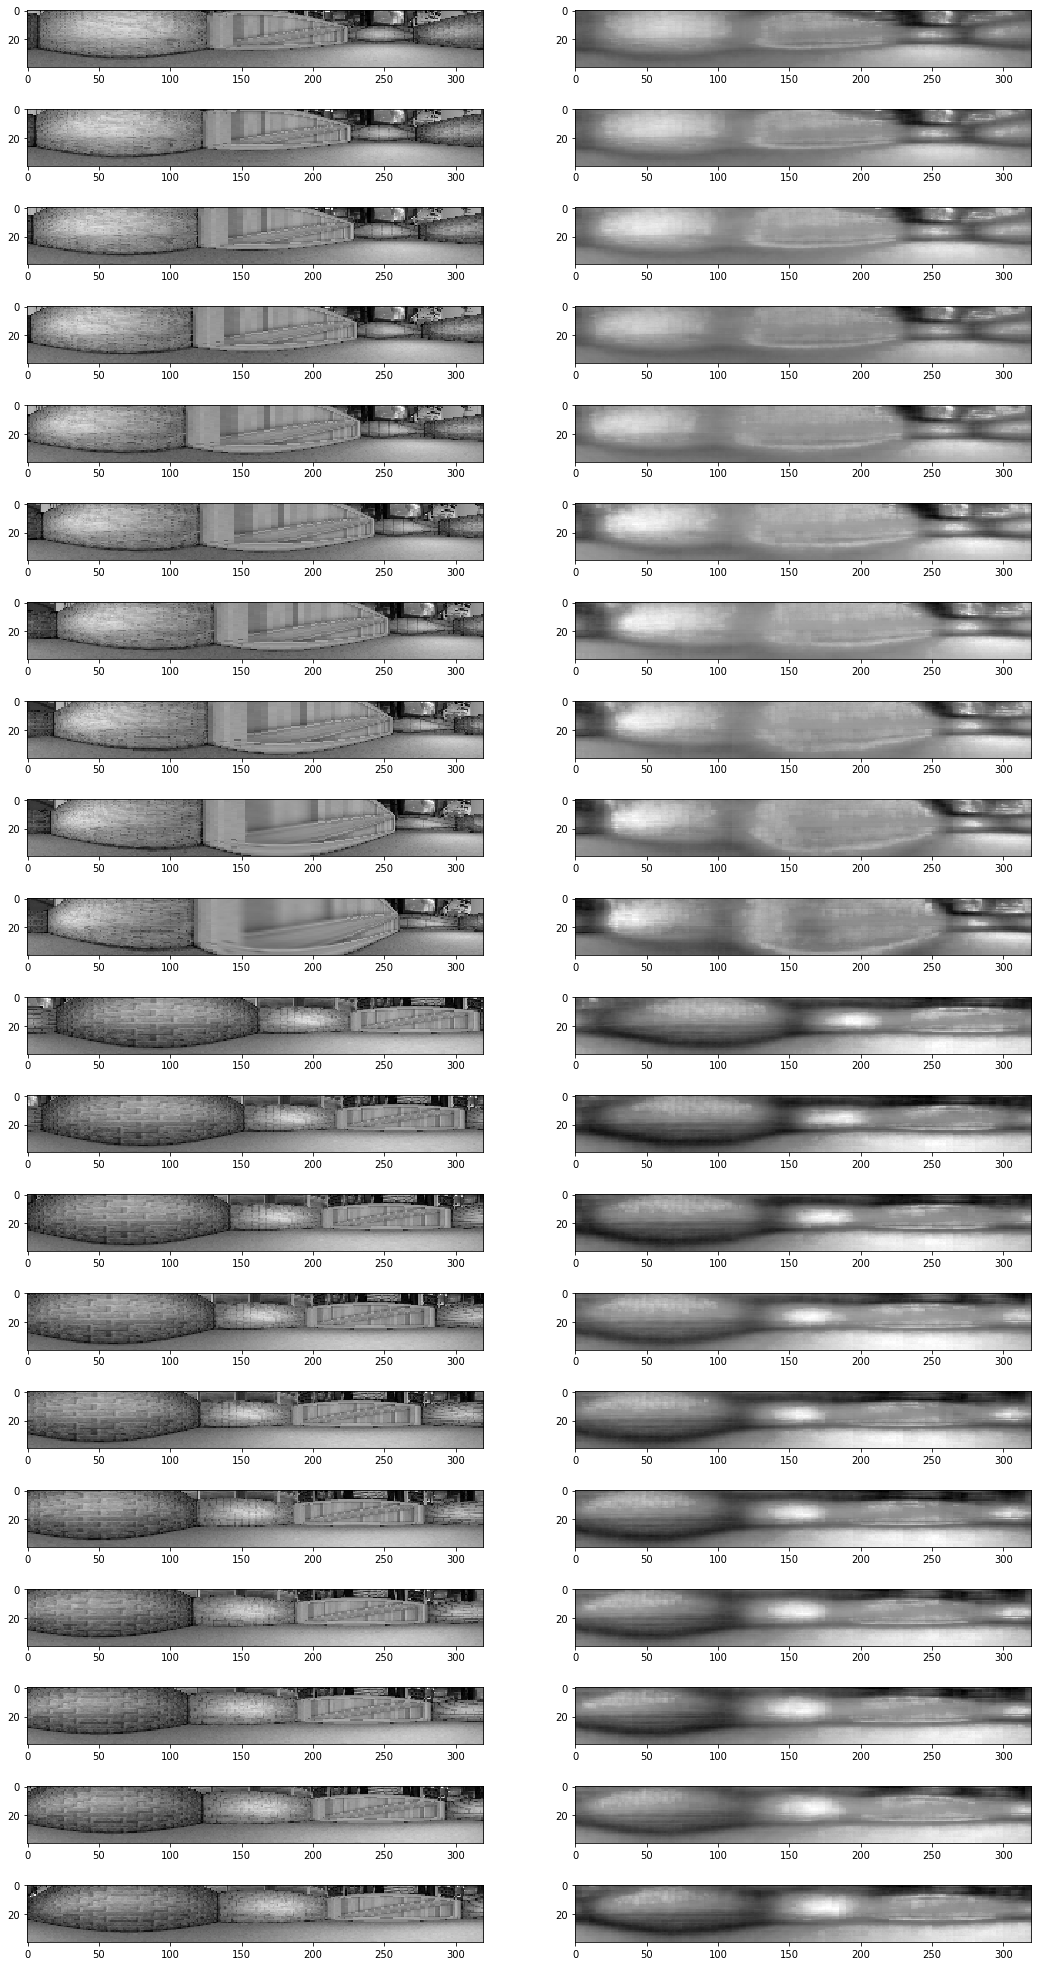

Model saved in file: C:/Users/WangYong/Desktop/Thesis/Code/model/modelxxx


In [37]:
# %%
# Fit training data
n_epochs = 40
for epoch_i in range(n_epochs):
    train0 = None
    for batch_i in range(train_images.shape[0] // batch_size):
        batch_xs = train_images[(batch_i*batch_size):((batch_i+1)*batch_size), :, :, :]
        train = np.array([img - mean_img for img in batch_xs])
        train0 = train
        steps_train = train_steps[(batch_i*batch_size):((batch_i+1)*batch_size-1)]
        angles_train = train_angles[(batch_i*batch_size):((batch_i+1)*batch_size-1)]
        sess.run(optimizer, feed_dict={ae['x']: train, ae['steps']:steps_train, ae['angles']:angles_train})
        
        batch_xs = train_images2[(batch_i*batch_size):((batch_i+1)*batch_size), :, :, :]
        train = np.array([img - mean_img2 for img in batch_xs])
        steps_train = train_steps2[(batch_i*batch_size):((batch_i+1)*batch_size-1)]
        angles_train = train_angles2[(batch_i*batch_size):((batch_i+1)*batch_size-1)]
        sess.run(optimizer, feed_dict={ae['x']: train, ae['steps']:steps_train, ae['angles']:angles_train})
    
    cost, cost1, cost2, z = sess.run([ae['cost'], ae['cost1'], ae['cost2'], ae['z']], feed_dict={ae['x']: train0})
    print(epoch_i, 'cost =', cost, 'cost1 =', cost1, 'cost2 =', cost2)
#     print('z.shape =', z.shape, '\n', np.reshape(z, (batch_size, 70)))
    
    cost, cost1, cost2, z = sess.run([ae['cost'], ae['cost1'], ae['cost2'], ae['z']], feed_dict={ae['x']: train})
    print(epoch_i, 'cost =', cost, 'cost1 =', cost1, 'cost2 =', cost2)
#     print('z.shape =', z.shape, '\n', np.reshape(z, (batch_size, 70)))

# %%
# Plot example reconstructions
n_examples = 10
start = int(rnd.random()*40000-11)

test_xs = train_images[start:(start+n_examples), :, :, :]
test_xs_norm = np.array([img - mean_img for img in test_xs])
steps_test = train_steps[start:(start+n_examples-1)]
angles_test = train_angles[start:(start+n_examples-1)]
recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm, ae['steps']:steps_test, ae['angles']:angles_test})

test_xs2 = train_images2[start:(start+n_examples), :, :, :]
test_xs_norm = np.array([img - mean_img2 for img in test_xs2])
steps_test = train_steps2[start:(start+n_examples-1)]
angles_test = train_angles2[start:(start+n_examples-1)]
recon2 = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm, ae['steps']:steps_test, ae['angles']:angles_test})

test_xs = np.concatenate((test_xs, test_xs2), axis=0)
recon = np.concatenate((recon, recon2), axis=0)
print(test_xs.shape, recon.shape)
fig, axs = plt.subplots(n_examples*2, 2, figsize=(18, 36))
for example_i in range(n_examples*2):
    axs[example_i][0].imshow(test_xs[example_i, :, :, 0], cmap='gray')
    if example_i < 10:
        axs[example_i][1].imshow(recon[example_i, :, :, 0] + mean_img[:, :, 0], cmap='gray')
    else:
        axs[example_i][1].imshow(recon[example_i, :, :, 0] + mean_img2[:, :, 0], cmap='gray')
plt.show()

saver = tf.train.Saver()
save_path = saver.save(sess, 'C:/Users/WangYong/Desktop/Thesis/Code/model/' + saved_model)
print("Model saved in file: %s" % save_path)

# Head and Place Cells Test

(12096, 40, 320, 1)
test_mean_img.shape = (40, 320, 1)
(12096, 3)
(12096,) 24
{3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0}
(12096,) 14
{3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0}
(12096,) 36
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0}


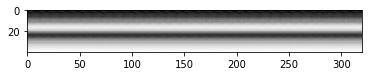

In [39]:
# load test data
test_images = np.load('test_images.npy')
print(test_images.shape)
test_mean_img = np.mean(test_images, axis=0)
print('test_mean_img.shape =', test_mean_img.shape)
plt.imshow(test_mean_img[:, :, 0], cmap='gray')

test_cmds = np.load('test_cmds.npy')
print(test_cmds.shape)
test_xs = test_cmds[:, 0]
test_x_set = set(test_xs)
print(test_xs.shape, len(test_x_set))
print(test_x_set)
test_ys = test_cmds[:, 1]
test_y_set = set(test_ys)
print(test_ys.shape, len(test_y_set))
print(test_y_set)
test_angles = test_cmds[:, 2]
test_angle_set = set(test_angles)
print(test_angles.shape, len(test_angle_set))
print(test_angle_set)

In [40]:
head_map_4_head_cell = np.zeros((36, 40))
place_map_4_head_cell = np.zeros((14, 24, 40))
head_map_4_place_cell = np.zeros((36, 30))
place_map_4_place_cell = np.zeros((14, 24, 30))

for idx in range(test_images.shape[0] // batch_size):
    batch_xs = test_images[(idx*batch_size):((idx+1)*batch_size), :, :, :]
    test_image = np.array([img - test_mean_img for img in batch_xs])
    test_x = test_xs[(idx*batch_size):((idx+1)*batch_size)]
    test_y = test_ys[(idx*batch_size):((idx+1)*batch_size)]
    test_angle = test_angles[(idx*batch_size):((idx+1)*batch_size)]
    Head_val, Place_val = sess.run([ae['Head'], ae['Place']], feed_dict={ae['x']: test_image})
    print(idx, 'Head_val.shape =', Head_val.shape, 'Place_val.shape =', Place_val.shape)
    for idx2 in range(batch_size):
        head_map_4_head_cell[test_angle[idx2].astype(int), :] += np.mean(Head_val, (1, 2))[idx2, :]
        place_map_4_head_cell[(test_y[idx2]-3).astype(int), (test_x[idx2]-3).astype(int), :] += np.mean(Head_val, (1, 2))[idx2, :]
        head_map_4_place_cell[test_angle[idx2].astype(int), :] += np.mean(Place_val, (1, 2))[idx2, :]
        place_map_4_place_cell[(test_y[idx2]-3).astype(int), (test_x[idx2]-3).astype(int), :] += np.mean(Place_val, (1, 2))[idx2, :]

0 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
2 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
3 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
4 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
5 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
6 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
7 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
8 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
9 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
10 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
11 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
12 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
13 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
14 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 

135 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
136 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
137 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
138 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
139 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
140 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
141 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
142 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
143 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
144 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
145 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
146 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
147 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
148 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
149 Head_val.shape = (10, 1, 1, 40

259 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
260 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
261 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
262 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
263 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
264 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
265 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
266 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
267 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
268 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
269 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
270 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
271 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
272 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
273 Head_val.shape = (10, 1, 1, 40

390 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
391 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
392 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
393 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
394 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
395 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
396 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
397 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
398 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
399 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
400 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
401 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
402 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
403 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
404 Head_val.shape = (10, 1, 1, 40

517 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
518 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
519 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
520 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
521 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
522 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
523 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
524 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
525 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
526 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
527 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
528 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
529 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
530 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
531 Head_val.shape = (10, 1, 1, 40

645 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
646 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
647 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
648 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
649 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
650 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
651 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
652 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
653 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
654 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
655 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
656 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
657 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
658 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
659 Head_val.shape = (10, 1, 1, 40

772 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
773 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
774 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
775 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
776 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
777 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
778 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
779 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
780 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
781 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
782 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
783 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
784 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
785 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
786 Head_val.shape = (10, 1, 1, 40

898 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
899 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
900 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
901 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
902 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
903 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
904 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
905 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
906 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
907 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
908 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
909 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
910 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
911 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
912 Head_val.shape = (10, 1, 1, 40

1024 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1025 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1026 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1027 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1028 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1029 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1030 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1031 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1032 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1033 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1034 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1035 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1036 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1037 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1038 Head_val.shape 

1147 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1148 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1149 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1150 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1151 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1152 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1153 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1154 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1155 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1156 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1157 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1158 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1159 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1160 Head_val.shape = (10, 1, 1, 40) Place_val.shape = (10, 1, 1, 30)
1161 Head_val.shape 

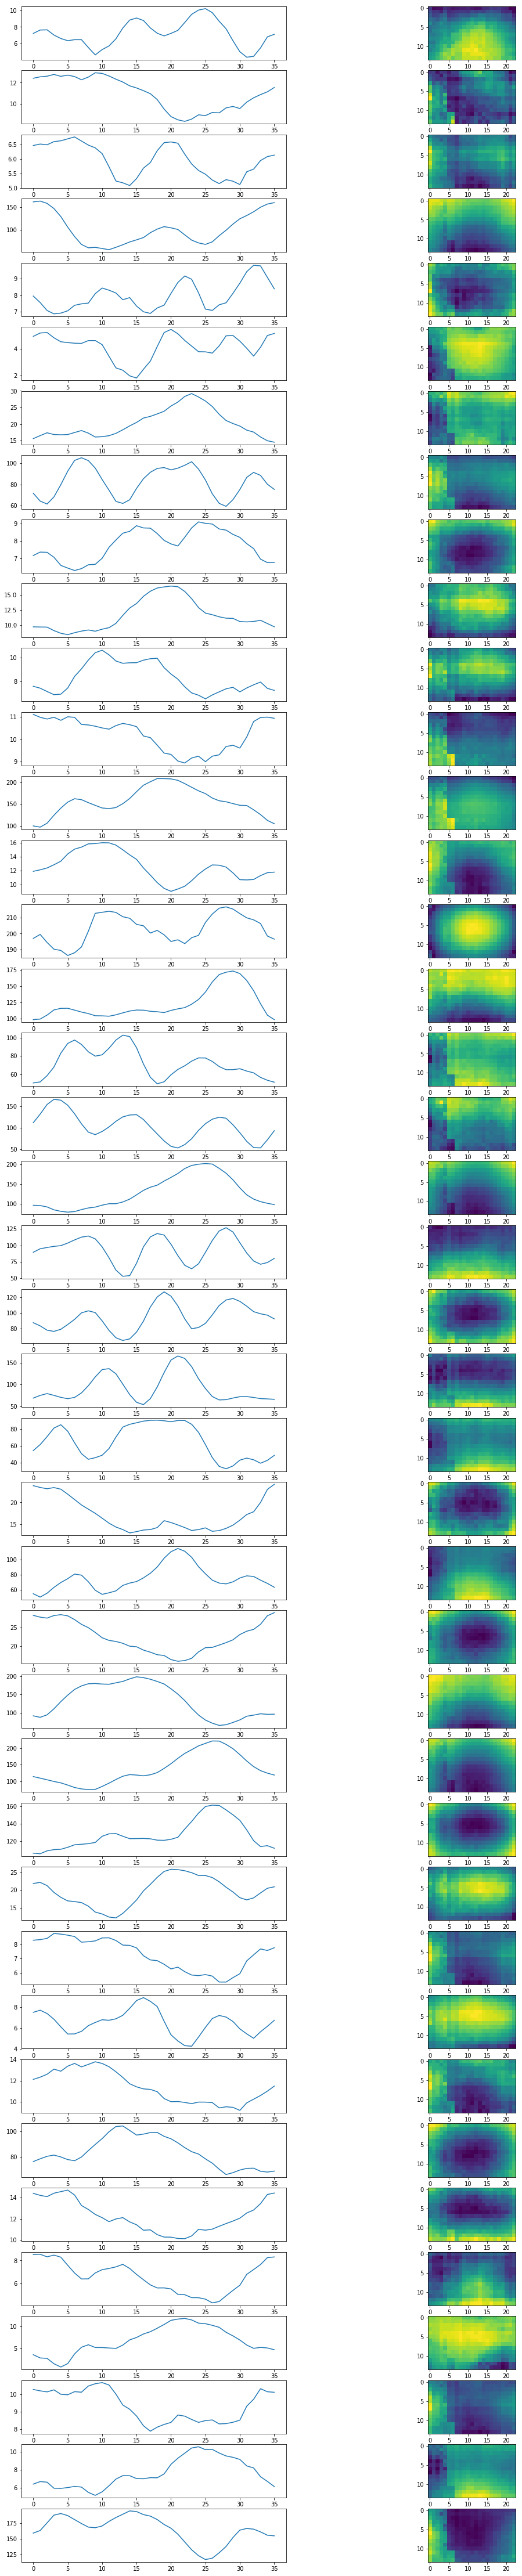

In [41]:
fig, axs = plt.subplots(40, 2, figsize=(18, 81))
for example_i in range(40):
    axs[example_i][0].plot(np.abs(head_map_4_head_cell[:, example_i]))
    axs[example_i][1].imshow(np.abs(place_map_4_head_cell[:, 0:23, example_i]))
plt.show()

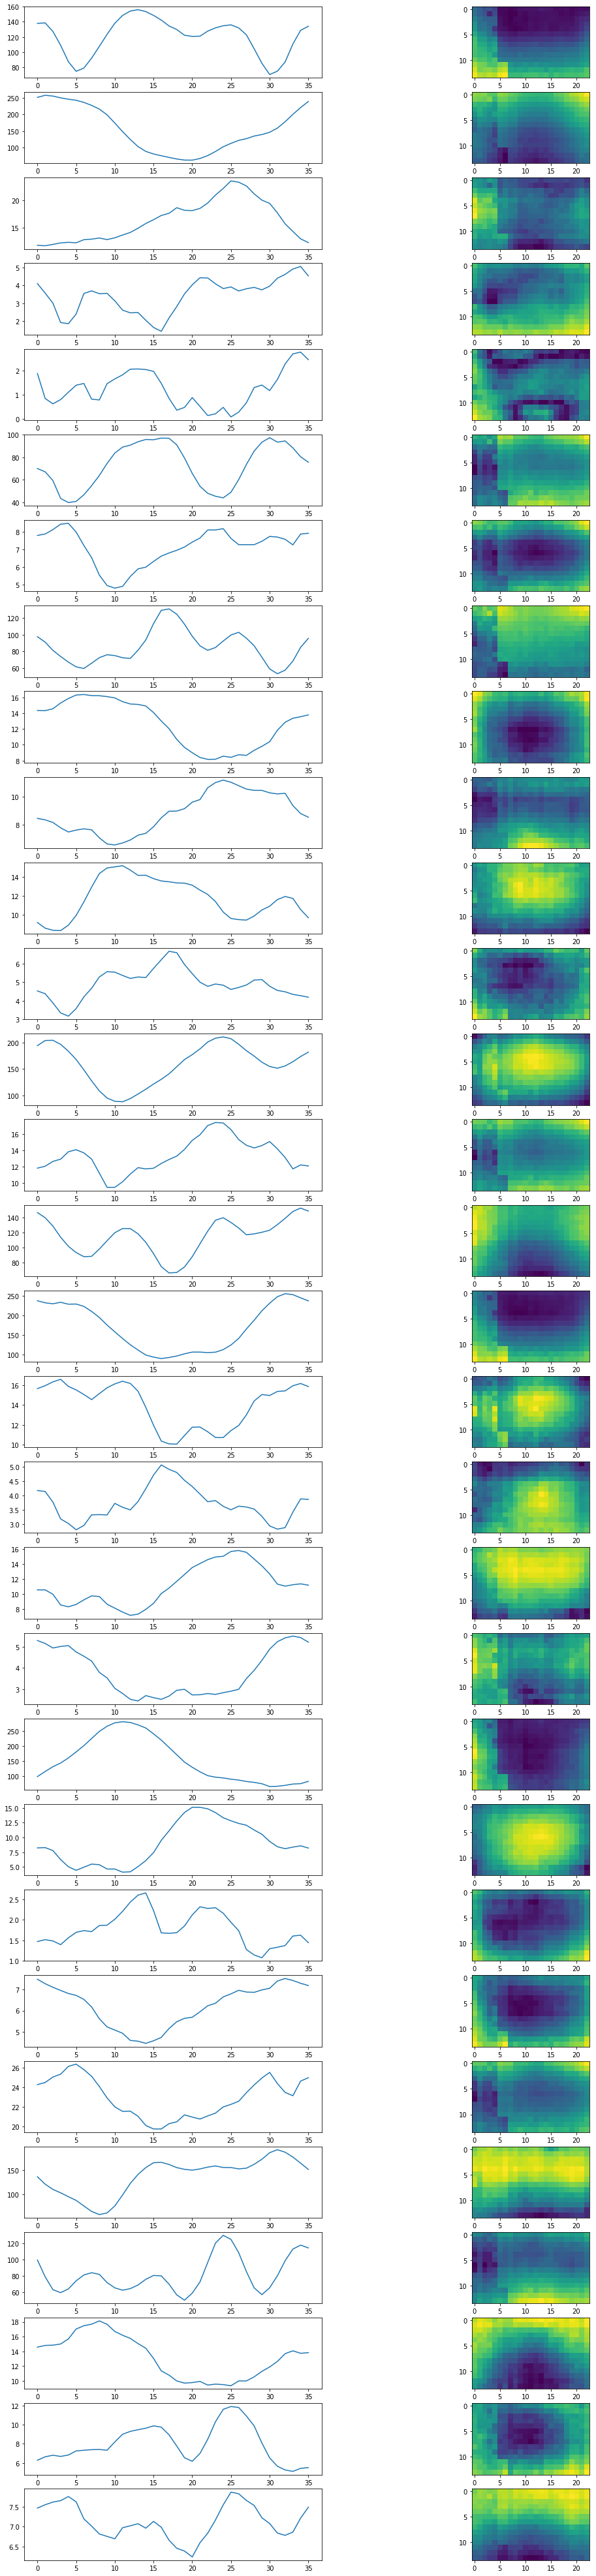

In [42]:
fig, axs = plt.subplots(30, 2, figsize=(18, 72))
for example_i in range(30):
    axs[example_i][0].plot(np.abs(head_map_4_place_cell[:, example_i]))
    axs[example_i][1].imshow(np.abs(place_map_4_place_cell[:, 0:23, example_i]))
plt.show()